#### Import libraries

In [ ]:
! pip install wandb

     |████████████████████████████████| 2.0MB 14.0MB/s 
     |████████████████████████████████| 163kB 54.6MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=349b3593c8fe97edf9fde770a97633b868cf91dd636704ef305f5bee815a4ebc
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=c692e42c38b378f957a51dbb279f1a352523e92343227637e035f7db6b604ba4
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
warnings.filterwarnings("ignore")
import wandb

In [ ]:
wandb.init(project="dl_assignment1", entity="ee17b154tony", name="assignment_1")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Download data

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Number of training examples
M = X_train.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = X_train.shape[1] * X_train.shape[2]

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1
y_train_one_hot = y_train_one_hot.T

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1
y_test_one_hot = y_test_one_hot.T

print("Number of images in the training set =", M)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 60000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


### Logging Sample Images

In [ ]:
# Store the index of first occurrence of each class
example_indices = [list(y_train).index(i) for i in range(num_classes)]

# example_images is a list containing one sample image per class, example_captions stores the corresponsing captions
example_images = []
example_captions = []
for index in example_indices:
    example_images.append(X_train[index])
    example_captions.append(class_names[y_train[index]])

# Log one sample image of each class to wandb
wandb.log({"Sample Image from each class": [wandb.Image(image, caption=caption) for image, caption in zip(example_images, example_captions)]})

### Number of neurons in the input and output layers

In [ ]:
input_nodes = num_features
output_nodes = num_classes

### Activation Functions and Derivatives

In [ ]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    # x is the tanh value
    return (1 - (np.tanh(x)**2))

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def ReLU(x):
    return x * (x > 0)

def ReLU_derivative(x):
    return x>0

### Loss Function and its derivatives

In [ ]:
def crossentropyloss(y, y_hat):
    """Categorical cross-entropy loss"""
    return -np.sum(y.reshape(y_hat.shape) * np.log(y_hat))

def crossentropyloss_derivative(y, y_hat):
    """Derivative of the cross entropy loss"""
    return -np.divide(y, y_hat)

### Initialization

In [ ]:
def initialize_parameters(layer_dims, initialization_option="random"):
    """
    This function is used to initialize the weights and biases of the network, using either 'random'
    or 'xavier' or 'normal' initialization depending on the parameter: initialization_option

    layer_dims is a list containing layer sizes (includes input and output layer).
    """
    np.random.seed(42)
    parameters = {} # Initialize parameter dictionary
    
    for i in range(1, len(layer_dims)):
        if initialization_option=="random":
          W = np.random.rand(layer_dims[i], layer_dims[i-1]) # uniform distribution

        elif initialization_option == "normal":
          W = np.random.randn(layer_dims[i], layer_dims[i-1]) # normal distribution

        elif initialization_option=="xavier":
          W = np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1])) # glorot normal distribution / Xavier

        # Initialize the biases with zeros
        b = np.zeros((layer_dims[i], 1))
        parameters["W"+str(i)] = W
        parameters["b"+str(i)] = b
    
    return parameters

### Forward Propagation

In [ ]:
def forward_propagation(X, parameters, batch_size=1, act_function="sigmoid"):
    """
    Given inputs X, it performs forward propagation and returns the output.
    """
    L = len(layer_dims) # total number of layers
    H = [None]*L # activations
    A = [None]*L # pre-activations
    H[0] = X.reshape((num_features, batch_size))
    
    for l in range(1, L):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        A[l] = np.dot(W, H[l-1]) + b # Computes the pre-activation
        if l == L-1:
            H[l] = softmax(A[l]) # activation function for output layers
        else:
            if act_function=="sigmoid":
                H[l] = sigmoid(A[l])
            elif act_function=="tanh":
                H[l] = tanh(A[l])
            elif act_function=="relu":
                H[l] = ReLU(A[l])
            
    output = H[L-1]
            
    return output, H, A

### Backpropagation

In [ ]:
def backprop(y_hat, y, H, A, parameters, act_function="sigmoid"):
    gradients = {}

    L = len(parameters)//2
    
    # Derivative of the loss function wrt A[L] 
    gradients["dA"+str(L)] = y_hat - y.reshape(-1, 1)   

    for l in range(L, 0, -1):
        gradients["dW"+str(l)] = np.dot(gradients["dA"+str(l)], H[l-1].T)
        gradients["db"+str(l)] = gradients["dA"+str(l)]
        gradients["dH"+str(l-1)] = np.dot(parameters["W"+str(l)].T, gradients["dA"+str(l)])

        if l > 1:
            if act_function=="sigmoid":
                gradients["dA"+str(l-1)] = np.multiply(gradients["dH"+str(l-1)], sigmoid_derivative(A[l-1]))
            elif act_function=="tanh":
                gradients["dA"+str(l-1)] = np.multiply(gradients["dH"+str(l-1)], tanh_derivative(A[l-1]))
            elif act_function=="relu":
                gradients["dA"+str(l-1)] = np.multiply(gradients["dH"+str(l-1)], ReLU_derivative(A[l-1]))
        
    return gradients

### Updating parameters

In [ ]:
def update_parameters_sgd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates

In [ ]:
def NN_model(X_train, y_train, X_test, y_test, layer_dims, learning_rate=0.001, beta=0.9,max_epochs=500):
    parameters = initialize_parameters(layer_dims)
    
    epoch_cost = [] # average training cost at the end of every epoch
    
    prev_epoch_cost = 100000 # some large initial value
    curr_epoch_cost = 0
    
    validation_epoch_cost = [] # average validation cost at the end of every epoch
    
    count=1 # keeps track of the number of epochs
    # An epoch is one complete pass through the training data

    while abs(prev_epoch_cost-curr_epoch_cost) > 1e-7 and count<=max_epochs:
        costs = []# training costs
        val_costs = []# validation costs
        count+=1# increment the number of epochs
        for i in range(len(X_train)):
            output, H, A = forward_propagation(X_train[i], parameters, act_function="sigmoid")
            cost = crossentropyloss(y_train[i], output)
            gradients = backprop(output, y_train[i], H, A, parameters, act_function="sigmoid")

            # print(gradients)

            parameters = update_parameters_sgd(parameters, gradients, learning_rate)

            # parameters, previous_updates = update_parameters_momentum(
            #                                                     parameters, gradients, learning_rate, beta,
            #                                                     previous_updates)
            costs.append(cost)
            
        # vaidation part (these examples do not contribute to parameter update)
        # therefore, the 'model' has still not seen these examples.
        for j in range(len(X_test)):
            out, _, _ = forward_propagation(X_test[j], parameters)
            cost = crossentropyloss(y_test[j], out)
            val_costs.append(cost)
            
        # average training loss for one epoch
        curr_epoch_cost = sum(costs)/len(X_train)
        if len(epoch_cost) >= 1:
            prev_epoch_cost = epoch_cost[-1]
        epoch_cost.append(curr_epoch_cost)
        print("Current_epoch cost =", curr_epoch_cost)
        # average validation loss for one epoch
        validation_epoch_cost.append(sum(val_costs)/len(X_test))
        
    plot_cost_curve(epoch_cost, validation_epoch_cost)
    return parameters, epoch_cost

#### Plot Cost Curve

In [ ]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training Loss vs Number of Epochs", size=18)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

### Predictions and Accuracy

In [ ]:
def predict(X, parameters):
    # X here is one training example
    pred, _, _ = forward_propagation(X, parameters)
    return pred

def predictions(X, parameters):
    # X is an array of many training examples
    y_pred = np.zeros(len(X))
    for i in range(len(X)):
        y_pred[i] = np.argmax(predict(X[i], parameters))
    return y_pred
        
def model_accuracy(predictions, y_truth):
    return np.mean(predictions == y_truth)*100

Current_epoch cost = 2.37927494799264
Current_epoch cost = 2.3789594263967584
Current_epoch cost = 2.378959426383531


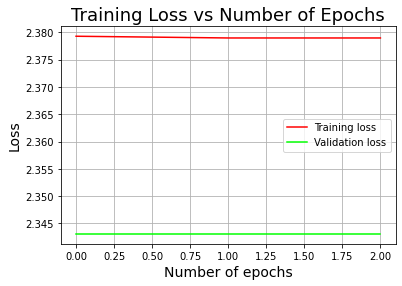

In [ ]:
layer_dims = [input_nodes, 32, 32, 32, output_nodes]
parameters, epoch_cost = NN_model(X_train, y_train_one_hot, X_test, y_test_one_hot, layer_dims, learning_rate=0.01, max_epochs=2000)

In [ ]:
epoch_cost

[nan]

In [ ]:
y_pred_train = predictions(X_train, parameters)
print("Training accuracy = {}%".format(round(model_accuracy(y_pred_train,y_train), 3)))

y_pred_test = predictions(X_test, parameters)
print("Test accuracy = {}%".format(round(model_accuracy(y_pred_test, y_test), 3)))

Training accuracy = 10.0%
Test accuracy = 10.0%


In [ ]:
y_pred_train

array([4., 4., 4., ..., 4., 4., 4.])